## Fingerprint Comparator

A relatively simple program to compare the ROC-AUC produced by different fingerprint methodologies available in Molfeat by Datamol.

Import dependencies

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from molfeat import calc, trans
import datamol as dm
from sklearn import ensemble, model_selection

Read a generic dataset. Must have a column of SMILES strings and a binary-coded DILI column.

In [2]:
tox_df_mf = pd.read_csv('Transformed_Data/Final_DILI.csv')

Instantiate a scikit-learn random forest classifier and define a function to compute the average ROC-AUC score.

In [3]:
model_rf_mf = ensemble.RandomForestClassifier(random_state=42)

def average(lst):
    return sum(lst) / len(lst)

In [5]:
from molfeat.store.modelstore import ModelStore, ModelStoreError

# store = ModelStore()
# store.search(name='ChemGPT-4.7M')[0]

### The main loop
* Create a tuple of Molfeat fingerprint types to compare
* Make a Pandas dataframe of SMILES strings
* Convert SMILES strings to an arbitrary Molfeat fingerprint type using Molfeat
* Set features & labels
* Average the ROC-AUC score of a scikit-learn classifier model across 5 cross-validations
* Print mean scores as they are computed & **append them to a list of scores**

In [ ]:
# regular_fingerprints = ('maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'secfp') # Tuple of fingerprint types to compare
# #regular_fingerprints = ('maccs', 'avalon')

# morgan_df_mf = pd.DataFrame(tox_df_mf['SMILES']) # New dataframe of just SMILES strings

# score_list = []

# for regular_fingerprint in regular_fingerprints:
#     fp_trans = trans.MoleculeTransformer(featurizer=regular_fingerprint) # Instantiate Molfeat transformer class implementing calculator defined above 
#     morgan_df_mf = np.array(fp_trans.transform(tox_df_mf['SMILES'].values)) # Generate fingerprints
    
#     X = morgan_df_mf # Features
#     y = tox_df_mf['DILI?'] # Labels
    
#     score = average(model_selection.cross_val_score(model_rf_mf, list(X), y, scoring='roc_auc', cv=5)) # Average AUC-ROC score across n cross-validations
#     print(f'{round(score, 3)} AUC-ROC for {regular_fingerprint} fingerprints') # Print AUC-ROC for each fingerprint type

#     score_list = score_list[:] + [score] # Append averaged ROC-AUC for each fingerprint to a list
    


In [ ]:
# huggingface_fingerprints = ['ChemGPT-4.7M']

# for huggingface_fingerprint in huggingface_fingerprints:
#     store.load(huggingface_fingerprint, download_output_dir=f"Hugging Face Models/{huggingface_fingerprint}")


In [20]:
regular_fingerprints = ('maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'secfp') # Tuple of fingerprint types to compare
huggingface_fingerprints = ['ChemGPT-4.7M']

from molfeat.trans import pretrained
from tqdm import tqdm

#morgan_df_mf = pd.DataFrame(tox_df_mf['SMILES']) # New dataframe of just SMILES strings

reg_fp_scores, hf_fp_scores = [], []

def reg_loop():
    for regular_fingerprint in regular_fingerprints:
        reg_fp_transformer = trans.MoleculeTransformer(featurizer=regular_fingerprint) # Instantiate Molfeat transformer class implementing calculator defined above 
        reg_df_mf = np.array(reg_fp_transformer.transform(tox_df_mf['SMILES'].values)) # Generate fingerprints
        
        X = reg_df_mf # Features
        y = tox_df_mf['DILI?'] # Labels
        
        reg_score = average(model_selection.cross_val_score(model_rf_mf, list(X), y, scoring='roc_auc', cv=5)) # Average AUC-ROC score across n cross-validations
        print(f'{round(reg_score, 3)} AUC-ROC for {regular_fingerprint} fingerprints') # Print AUC-ROC for each fingerprint type
        reg_score_list = reg_fp_scores[:] + [reg_score] # Append averaged ROC-AUC for each fingerprint to a list

def hf_loop():
    for huggingface_fingerprint in tqdm(huggingface_fingerprints):
        hf_fp_transformer = pretrained.PretrainedHFTransformer(kind=huggingface_fingerprint) # Requires fsspec 2023.6.0 (conda install -c conda-forge fsspec v2023.6.0)
        hf_df_mf = np.array(hf_fp_transformer.transform(tox_df_mf['SMILES'].values)) # Generate fingerprints
        
        X2 = hf_df_mf # Features
        y2 = tox_df_mf['DILI?'] # Labels
        
        hf_score = average(model_selection.cross_val_score(model_rf_mf, list(X2), y2, scoring='roc_auc', cv=5)) # Average AUC-ROC score across n cross-validations
        print(f'{round(hf_score, 3)} AUC-ROC for {huggingface_fingerprints} fingerprints') # Print AUC-ROC for each fingerprint type
        hf_score_list = hf_fp_scores[:] + [hf_score] # Append averaged ROC-AUC for each fingerprint to a list

import threading

p1 = threading.Thread(target=reg_loop)
p2 = threading.Thread(target=hf_loop)

p1.start()
p2.start()

print("It doesn't look like it's working, but it is.")

  0%|          | 0/1 [00:00<?, ?it/s]

0.892 AUC-ROC for maccs fingerprints
0.887 AUC-ROC for avalon fingerprints
0.875 AUC-ROC for ecfp fingerprints
0.866 AUC-ROC for fcfp fingerprints
0.867 AUC-ROC for topological fingerprints
0.891 AUC-ROC for atompair fingerprints
0.872 AUC-ROC for rdkit fingerprints
0.859 AUC-ROC for pattern fingerprints
0.893 AUC-ROC for layered fingerprints
0.875 AUC-ROC for secfp fingerprints


100%|██████████| 1/1 [02:40<00:00, 160.32s/it]

0.859 AUC-ROC for ['ChemGPT-4.7M'] fingerprints


Create a Pandas dataframe
* Column 1 - Fingerprint
* Column 2 - Mean ROC-AUC score for that fingerprint across 5 cross-validations

In [23]:
scores_df = pd.DataFrame(data=(regular_fingerprints, score_list)).transpose() # Create a Pandas dataframe of the AUC-ROC scores and the fingerprint type associated with that score
scores_df = (scores_df
    .rename(columns={0: 'Fingerprint', 1: 'Score (ROC-AUC)'})
)

Chart presentation calculations
* Compute mean AUC-ROC score. This is used to set a the baseline (mean) score
* Add a dataframe column for the size of the ROC-AUC score when the normalised chart is used. Necessary to prevent full-size bar being shown as should be in the case when 0 is the baseline.
* Sort dataframe so the chart is sorted

In [24]:
scores_mean = average(scores_df['Score (ROC-AUC)']) # Compute average AUC-ROC score for purposes of barchart normalisation
scores_df['Score (ROC-AUC) - Normalised to Mean'] = scores_df['Score (ROC-AUC)'] - scores_mean # Barchart bar height absolute, so subtract the mean from the bar height. Otherwise bars will have their bases at `mean`, but still be full height (as if they were at a base of 0)

scores_df = scores_df.sort_values('Score (ROC-AUC) - Normalised to Mean', ascending=False) # Sort the Pandas DF In descending order

Seaborn barplot generation - Normalised to mean with rotated X-axis labels

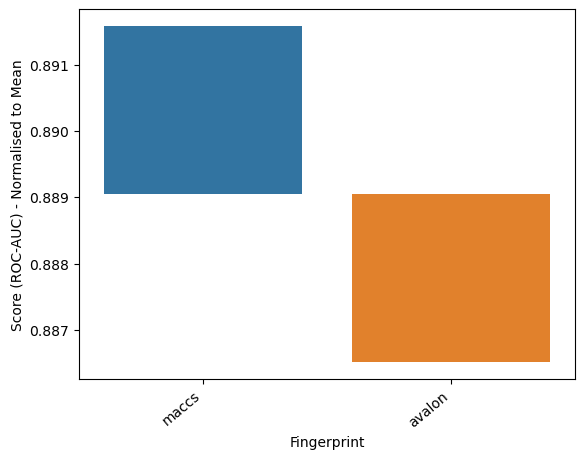

In [25]:
# Generate a Seaborn barplot
fp_plot = sns.barplot(
    scores_df,
    x='Fingerprint',
    y='Score (ROC-AUC) - Normalised to Mean',
    hue='Fingerprint',
    bottom=scores_mean
)

# The semicolons at the line end stop Seaborn printing a dataframe
fp_plot.xaxis.set_ticks(scores_df['Fingerprint']); # Prevent Seaborn error if x-axis ticks not explicitly defined before the next line is run
fp_plot.set_xticklabels(fp_plot.get_xticklabels(), rotation=40, ha='right'); # Rotate X-axis labels

In [ ]:
## Previous implementation of the fingerpirnt generator & comparator loop - Ignore, but it will work if you uncomment it.

# fp_list = ['maccs', 'avalon', 'ecfp', 'ecfp-count', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'secfp']

# score_list = []
# for fingerprint in fp_list:
#     fp_calc = calc.FPCalculator(fingerprint)
#     fp_trans = trans.MoleculeTransformer(fp_calc)
#     tox_df_mf["fp"] = fp_trans.transform(tox_df_mf['SMILES'].values)
#     morgan_df_mf = pd.DataFrame(tox_df_mf['fp'])
#     morgan_df_mf.insert(len(morgan_df_mf.columns), 'DILI?', tox_df_mf['DILI?'].astype(int)) # Insert 'DILI?' column as the last column
#     morgan_df_mf.columns = morgan_df_mf.columns.astype(str) # Set all column titles to string - Required for model
#     X = morgan_df_mf['fp'] # Features
#     y = morgan_df_mf['DILI?'] # Labels
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size = 0.75)
    
#     score = average(model_selection.cross_val_score(model_rf_mf, list(X), y, scoring='roc_auc', cv=5))
#     print(f'{round(score, 3)} AUC-ROC for {fingerprint} fingerprints')

#     score_list = score_list[:] + [score]

Version 0.1 completed on 24/10/23 @ ~ 11pm

## Thanks to

For the fingerprint comparator and visualisation concept  
https://sergeykolchenko.medium.com/evaluating-molecular-representations-for-property-prediction-a-computational-chemistry-approach-93246c75be6a

For examples on implementing Molfeat calculators and transformers  
https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/QSAR_in_8_lines.ipynb#scrollTo=8488ccfb

For barchart normalisation  
https://stackoverflow.com/questions/67037903/how-do-i-plot-a-barchart-from-the-datasets-mean-value-and-not-its-default-0-valu

For barchart X-axis ordering  
https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering

For reducing Seaborn complaining
https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator

To fix a Jupyter Notebook warning
https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an